이번 코드에서 할 내용
1. IR Curve 양상 용량 열화 커브처럼 색 나타내서
2. 데이터가 논문에서 제공한 히스토그램과 다름을 보여주기
3. Capacity fade curve, cycle 100 에서 라벨이 잘못된것 고치기
4. Full model classification 만들기
5. Batch 정보, 00 , 00 , 00(추후 추가적으로 넣을 데이터 생각) 를 사용한 딥러닝 모델 만들고, 어떤 딥러닝 모델을 사용할지.
6. 방전 전압 곡선,(time(date or time +batch info), voltage), cycle 데이터만 이용해서 (3~4차원 raw 데이터) Cycle life 예측해보기

# 1. IR Curve

In [1]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy import stats

batch1 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())



batch2 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch2.pkl','rb'))
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']


numBat2 = len(batch2.keys())

batch3 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}

In [2]:
#bat_dict keys
bat_dict.keys()

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47', 'b3c0', 'b3c1', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b3c19', 'b3c20', 'b3c21', 'b3c22', 'b3c24', 'b3c25', 'b3c26', 'b3c27', 'b3c28', 'b3c29', 'b3c30

In [3]:
# b1c0 keys()
bat_dict['b1c0'].keys()

dict_keys(['cycle_life', 'charge_policy', 'summary', 'cycles'])

In [4]:
#summary 에 IR 있음.
bat_dict['b1c0']['summary'].keys()

dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])

In [5]:
#y 축에 사용할 IR 값 (numpy 배열임)
bat_dict['b1c0']['summary']['IR']

array([0.        , 0.01674235, 0.01672431, ..., 0.0181332 , 0.0181233 ,
       0.0181211 ])

In [6]:
# x 축에 사용할 cycle 값 (numpy 배열임)
bat_dict['b1c0']['summary']['cycle']

array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.849e+03, 1.850e+03,
       1.851e+03])

In [7]:
x=bat_dict['b1c0']['summary']['cycle']
y=bat_dict['b1c0']['summary']['IR']

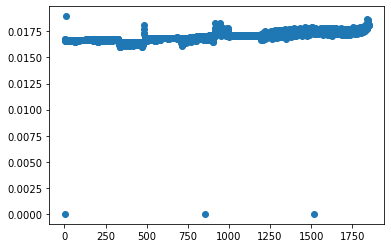

In [8]:
plt.scatter(x,y)

In [9]:
# 색 조절
sort=[]
for i in bat_dict.keys():
    a=len(bat_dict[i]['summary']['cycle'])
    sort.append([a,i])

Text(0.5, 1.0, 'MinMaxScale Color')

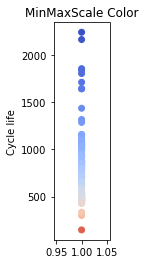

In [10]:
# 색 조절.
color=[]
cycle_=[]
plt.figure(figsize=(1,4))
for i,j in enumerate(bat_dict.keys()):
    sortcycle=bat_dict[j]['cycle_life']
    cycle_.append(sortcycle.tolist())
    c=(np.log10(sortcycle)-2)/(np.log10(2300)-2)
    color.append(c.tolist())

a=np.array(color).ravel()
b=np.array(cycle_).ravel()
changecolor=cm.coolwarm_r(a)
plt.scatter(np.ones(len(a)),b,c=cm.coolwarm_r(a))
plt.ylabel("Cycle life")
plt.title("MinMaxScale Color")

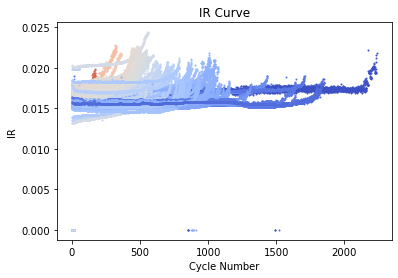

In [11]:
for i,j in enumerate(bat_dict.keys()):
    plt.scatter(bat_dict[j]['summary']['cycle'], bat_dict[j]['summary']['IR'],s=1,color=changecolor[i])
plt.xlabel('Cycle Number')
#plt.xlim(0,1000)
plt.ylabel('IR')
#plt.ylim(0.88,1.10)
plt.title("IR Curve")
plt.show()

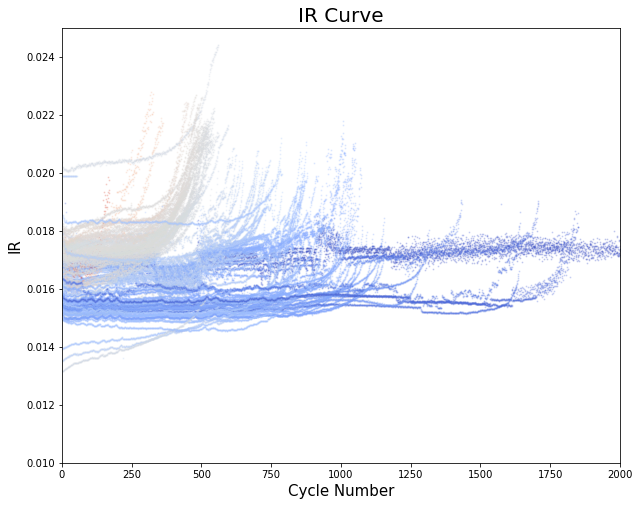

In [12]:
plt.figure(figsize=(10,8))
for i,j in enumerate(bat_dict.keys()):
    plt.scatter(bat_dict[j]['summary']['cycle'], bat_dict[j]['summary']['IR'],s=1,color=changecolor[i],alpha=0.2)
plt.xlabel('Cycle Number',fontsize=15)
plt.xlim(0,2000)
plt.ylabel('IR',fontsize=15)
plt.ylim(0.01,0.025)
plt.title("IR Curve",fontsize=20)
plt.show()

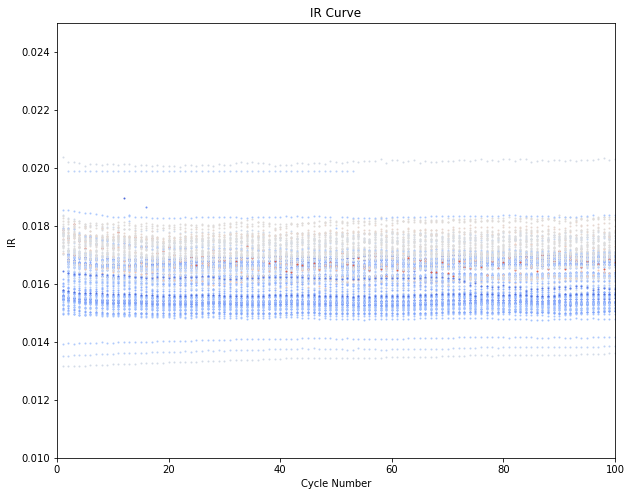

In [13]:
plt.figure(figsize=(10,8))
for i,j in enumerate(bat_dict.keys()):
    plt.scatter(bat_dict[j]['summary']['cycle'], bat_dict[j]['summary']['IR'],s=1,color=changecolor[i])
plt.xlabel('Cycle Number')
plt.xlim(0,100)
plt.ylabel('IR')
plt.ylim(0.01,0.025)
plt.title("IR Curve")
plt.show()

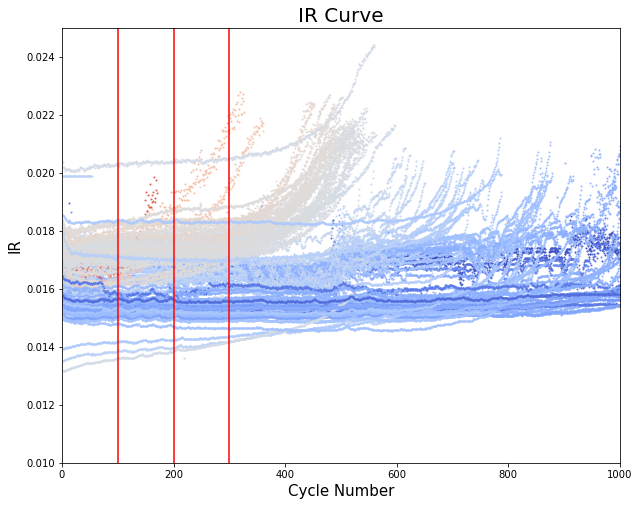

In [19]:
plt.figure(figsize=(10,8))
for i,j in enumerate(bat_dict.keys()):
    plt.scatter(bat_dict[j]['summary']['cycle'], bat_dict[j]['summary']['IR'],s=1,color=changecolor[i])
plt.xlabel('Cycle Number',fontsize=15)
plt.xlim(0,1000)
plt.ylabel('IR',fontsize=15)
plt.ylim(0.01,0.025)
plt.title("IR Curve",fontsize=20)
plt.plot(np.full(100,100),np.linspace(0.01,0.03,100),color='red')
plt.plot(np.full(100,300),np.linspace(0.01,0.03,100),color='red')
plt.plot(np.full(100,200),np.linspace(0.01,0.03,100),color='red')
plt.show()

# 2. 데이터가 논문에서 제공한 히스토그램과 다름을 보여주기

In [31]:
bat_dict['b1c0']['cycle_life']

array([[1852.]])

In [32]:
len(bat_dict.keys())

124

124 개의 데이터를 히스토그램으로 만들기

In [36]:
cycle_info=[]
for i,j in enumerate(bat_dict.keys()):
    cycle_info.append(bat_dict[j]['cycle_life'][0][0].tolist())
print(cycle_info)

[1852.0, 2160.0, 2237.0, 1434.0, 1709.0, 1074.0, 636.0, 870.0, 1054.0, 788.0, 880.0, 719.0, 862.0, 857.0, 691.0, 788.0, 534.0, 559.0, 1014.0, 1017.0, 854.0, 870.0, 842.0, 860.0, 917.0, 709.0, 876.0, 731.0, 757.0, 742.0, 703.0, 704.0, 648.0, 617.0, 625.0, 966.0, 1051.0, 702.0, 651.0, 616.0, 599.0, 300.0, 148.0, 438.0, 335.0, 444.0, 480.0, 511.0, 561.0, 477.0, 458.0, 483.0, 485.0, 494.0, 487.0, 461.0, 502.0, 489.0, 513.0, 527.0, 495.0, 461.0, 471.0, 468.0, 509.0, 498.0, 481.0, 492.0, 519.0, 520.0, 499.0, 463.0, 535.0, 478.0, 465.0, 459.0, 499.0, 429.0, 466.0, 462.0, 457.0, 487.0, 429.0, 713.0, 1009.0, 1063.0, 1115.0, 1048.0, 828.0, 667.0, 1836.0, 828.0, 1039.0, 1078.0, 817.0, 932.0, 816.0, 858.0, 876.0, 1638.0, 1315.0, 1146.0, 1155.0, 813.0, 772.0, 1002.0, 825.0, 989.0, 1028.0, 850.0, 541.0, 858.0, 935.0, 731.0, 1284.0, 1158.0, 1093.0, 923.0, 796.0, 786.0, 1642.0, 1046.0, 940.0, 1801.0]


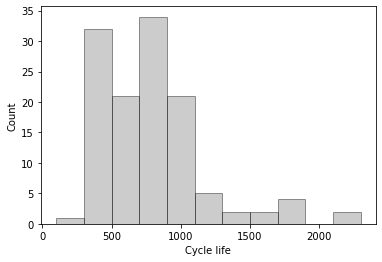

In [38]:
bins=np.arange(100,2500,200)# width 조절
plt.hist(cycle_info,bins,color='gray',edgecolor='k',alpha=0.4)
plt.xlabel('Cycle life')
plt.ylabel('Count')
plt.show()

위 히스토그램은 전체 이제 Train, Primary, Secondary test 데이터로 분할해서 나타내기.

In [39]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

In [40]:
test_label=[]
train_label=[]
sec_label=[]
for i,j in enumerate(bat_dict.keys()):
    if i in test_ind :
        cycle_test=bat_dict[j]['cycle_life'].tolist()
        test_label.append(cycle_test[0][0])
        
    if i in train_ind :
        cycle_train=bat_dict[j]['cycle_life'].tolist()
        train_label.append(cycle_train[0][0])
            
    if i in secondary_test_ind:
        cycle_sec=bat_dict[j]['cycle_life'].tolist()
        sec_label.append(cycle_sec[0][0])

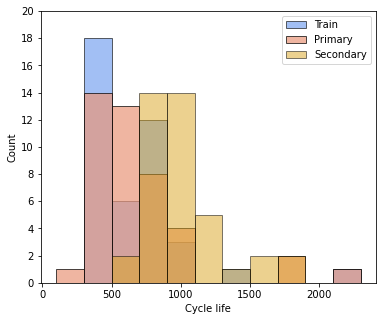

In [62]:
bins=np.arange(100,2500,200)# width 조절
plt.figure(figsize=(6,5))
plt.hist(train_label,bins,edgecolor='k',alpha=0.6,color='cornflowerblue',label='Train')
plt.hist(test_label,bins,edgecolor='k',alpha=0.7,color='darksalmon',label='Primary')
plt.hist(sec_label,bins,edgecolor='k',alpha=0.5,color='goldenrod',label='Secondary')
plt.yticks(np.arange(0,21,2))
plt.xlabel('Cycle life')
plt.ylabel('Count')
plt.legend()

# 3. Capacity fade curve, cycle 100 에서 라벨이 잘못된것 고치기

In [81]:
#“Constant”: univariate model using only the average cycle life of the training set for all predictions

bat1_2 = {**batch1, **batch2}

prim_test_cycle=[]
Train_cycle=[]
secondary_cycle=[]
for i,j in enumerate(bat1_2.keys()):
    cycle=bat_dict[j]['cycle_life'].tolist()
    if i==83:
        prim_test_cycle.append(cycle)
        break
    if i%2==0:
        prim_test_cycle.append(cycle)
    if i%2==1:
        Train_cycle.append(cycle)
for i,j in enumerate(batch3.keys()):
    cycle=bat_dict[j]['cycle_life'].tolist()
    secondary_cycle.append(cycle)

cycle1=np.log10(Train_cycle)
cycle2=np.log10(prim_test_cycle)
cycle3=np.log10(secondary_cycle)    
    
    
arr=np.log10(np.array(Train_cycle)/2)
cyc=np.array(cycle1).ravel()

    
    
arr2=np.log10(np.array(prim_test_cycle)/2)  
cyc2=np.array(cycle2).ravel()

    
    
arr3=np.log10(np.array(secondary_cycle)/2)
cyc3=np.array(cycle3).ravel()

    
    
    
def Z_score(Train,prim_test,secondary):
    Z1=(Train-np.mean(Train))/np.std(Train)
    Z2=(prim_test-np.mean(Train))/np.std(Train)
    Z3=(secondary-np.mean(Train))/np.std(Train)
    return Z1, Z2, Z3    
Z1,Z2,Z3=Z_score(arr,arr2,arr3)    

In [82]:
label_=cyc
label_.shape

(41,)

In [83]:
label2=cyc2

In [84]:
label3=cyc3

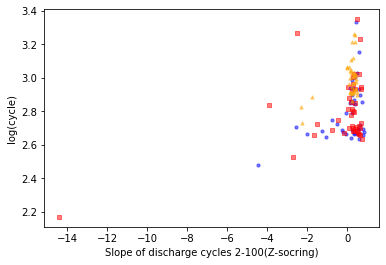

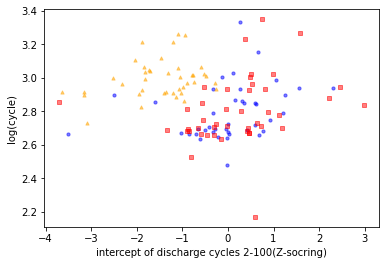

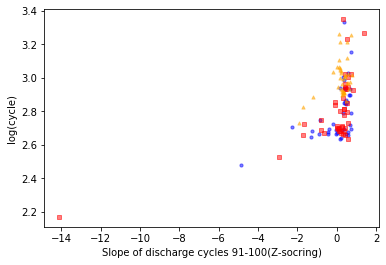

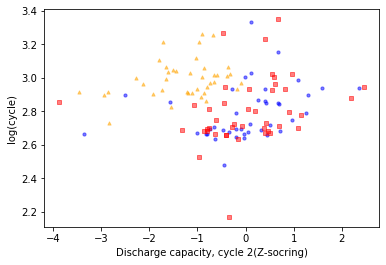

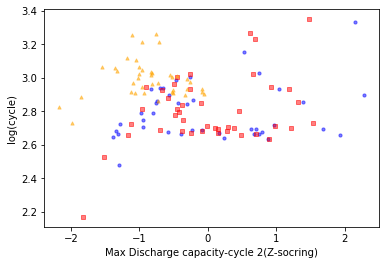

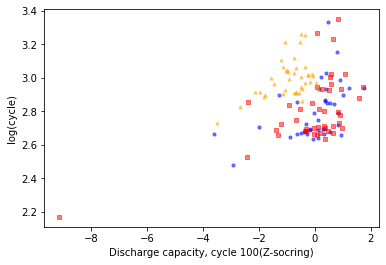

In [85]:
#Slope of capacity fade curve, cycles 2 to 100
prim=[]
Train=[]
secondary=[]
from sklearn.linear_model import LinearRegression
Xvalue=np.array(range(2,101)).reshape(-1,1)
for i,j in enumerate(bat1_2.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(2,101):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)        
        
    if i==83:
        prim.append(reg.coef_)
        break
    if i%2==0:
        prim.append(reg.coef_)
    if i%2==1:
        Train.append(reg.coef_)
for i,j in enumerate(batch3.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(2,101):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)   
    secondary.append(reg.coef_)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z1_1,Z1_2,Z1_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z1_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z1_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z1_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Slope of discharge cycles 2-100(Z-socring)')
plt.show()

#Slope of capacity fade curve, cycles 2 to 100
prim=[]
Train=[]
secondary=[]
from sklearn.linear_model import LinearRegression
Xvalue=np.array(range(2,101)).reshape(-1,1)
for i,j in enumerate(bat1_2.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(2,101):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)        
    if i==83:
        prim.append(reg.intercept_)
        break
    if i%2==0:
        prim.append(reg.intercept_)
    if i%2==1:
        Train.append(reg.intercept_)
for i,j in enumerate(batch3.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(2,101):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)   
    secondary.append(reg.intercept_)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z2_1,Z2_2,Z2_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z2_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z2_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z2_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('intercept of discharge cycles 2-100(Z-socring)')
plt.show()

# “Slope of discharge cycles 91-100”: univariate model using only the slope of the linear fit for discharge capacity, cycles 91-100
prim=[]
Train=[]
secondary=[]
from sklearn.linear_model import LinearRegression
Xvalue=np.array(range(91,101)).reshape(-1,1)
for i,j in enumerate(bat1_2.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(91,101):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)        
        
    if i==83:
        prim.append(reg.coef_)
        break
    if i%2==0:
        prim.append(reg.coef_)
    if i%2==1:
        Train.append(reg.coef_)
for i,j in enumerate(batch3.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(91,101):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)   
    secondary.append(reg.coef_)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z3_1,Z3_2,Z3_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z3_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z3_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z3_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Slope of discharge cycles 91-100(Z-socring)')
plt.show()

# “Discharge capacity, cycle 2
prim=[]
Train=[]
secondary=[]
for i,j in enumerate(bat1_2.keys()):
    Cycle2=bat_dict[j]['summary']['QD'][2]

    if i==83:
        prim.append(Cycle2)
        break
    if i%2==0:
        prim.append(Cycle2)
    if i%2==1:
        Train.append(Cycle2)
for i,j in enumerate(batch3.keys()):
    Cycle2=bat_dict[j]['summary']['QD'][2]
    secondary.append(Cycle2)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z4_1,Z4_2,Z4_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z4_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z4_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z4_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Discharge capacity, cycle 2(Z-socring)')
plt.show()

# “Max Discharge capacity-cycle 2'
prim=[]
Train=[]
secondary=[]
for i,j in enumerate(bat1_2.keys()):
    a=np.array(bat_dict[j]['summary']['QD'])
    de=np.where(a>1.2)
    a=np.delete(a,de)
    max_Q_cycle2=max(a)-a[2]
    
    if i==83:
        prim.append(max_Q_cycle2)
        break
    if i%2==0:
        prim.append(max_Q_cycle2)
    if i%2==1:
        Train.append(max_Q_cycle2)
for i,j in enumerate(batch3.keys()):
    a=np.array(bat_dict[j]['summary']['QD'])
    de=np.where(a>1.2)
    a=np.delete(a,de)
    max_Q_cycle2=max(a)-a[2]
    secondary.append(max_Q_cycle2)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z5_1,Z5_2,Z5_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z5_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z5_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z5_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Max Discharge capacity-cycle 2(Z-socring)')
plt.show()

# “Discharge capacity, cycle 100'
prim=[]
Train=[]
secondary=[]
for i,j in enumerate(bat1_2.keys()):
    Cycle100=bat_dict[j]['summary']['QD'][100]

    if i==83:
        prim.append(Cycle100)
        break
    if i%2==0:
        prim.append(Cycle100)
    if i%2==1:
        Train.append(Cycle100)
for i,j in enumerate(batch3.keys()):
    Cycle100=bat_dict[j]['summary']['QD'][100]
    secondary.append(Cycle100)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z6_1,Z6_2,Z6_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z6_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z6_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z6_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Discharge capacity, cycle 100(Z-socring)')
plt.show()

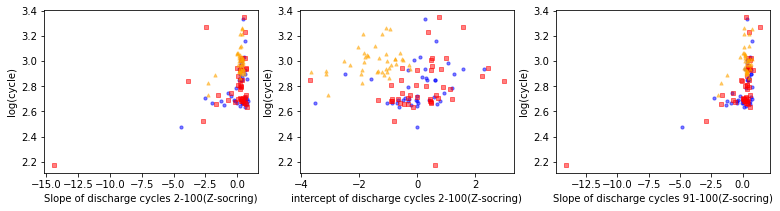

<Figure size 432x288 with 0 Axes>

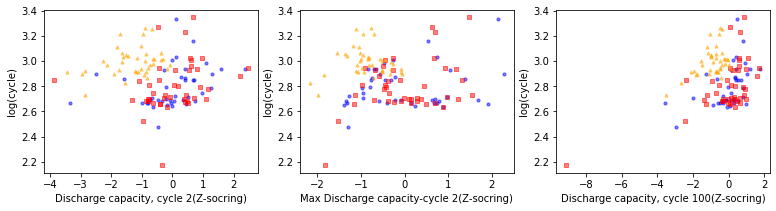

In [86]:
fig=plt.figure(figsize=(13,3))
ax1=fig.add_subplot(1,3,1)
ax1.scatter(Z1_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax1.scatter(Z1_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax1.scatter(Z1_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax1.set_ylabel('log(cycle)')
ax1.set_xlabel('Slope of discharge cycles 2-100(Z-socring)')

ax2=fig.add_subplot(1,3,2)
ax2.scatter(Z2_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax2.scatter(Z2_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax2.scatter(Z2_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax2.set_ylabel('log(cycle)')
ax2.set_xlabel('intercept of discharge cycles 2-100(Z-socring)')

ax3=fig.add_subplot(1,3,3)
ax3.scatter(Z3_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax3.scatter(Z3_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax3.scatter(Z3_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax3.set_ylabel('log(cycle)')
ax3.set_xlabel('Slope of discharge cycles 91-100(Z-socring)')
plt.show()

plt.clf()
fig=plt.figure(figsize=(13,3))
ax4=fig.add_subplot(1,3,1)
ax4.scatter(Z4_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax4.scatter(Z4_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax4.scatter(Z4_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax4.set_ylabel('log(cycle)')
ax4.set_xlabel('Discharge capacity, cycle 2(Z-socring)')

ax5=fig.add_subplot(1,3,2)
ax5.scatter(Z5_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax5.scatter(Z5_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax5.scatter(Z5_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax5.set_ylabel('log(cycle)')
ax5.set_xlabel('Max Discharge capacity-cycle 2(Z-socring)')

ax6=fig.add_subplot(1,3,3)
ax6.scatter(Z6_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax6.scatter(Z6_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax6.scatter(Z6_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax6.set_ylabel('log(cycle)')
ax6.set_xlabel('Discharge capacity, cycle 100(Z-socring)')
plt.show()

In [87]:
Train=np.hstack([Z1_1,Z2_1,Z3_1,Z4_1,Z5_1,Z6_1])
Train.shape , label_.shape

((41, 6), (41,))

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2639596964713159, tolerance: 0.10703521221153374
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

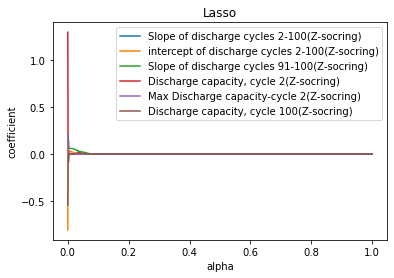

In [88]:
Y_lasso=[]
X_lasso=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=Lasso(alpha=i,tol=0.1)
    regrplot.fit(Train,label_)
    Y_lasso.append(regrplot.coef_)
    X_lasso.append(i)
Y_=np.array(Y_lasso)    

plt.plot(X_lasso,Y_[:,0],label='Slope of discharge cycles 2-100(Z-socring)')
plt.plot(X_lasso,Y_[:,1],label='intercept of discharge cycles 2-100(Z-socring)')
plt.plot(X_lasso,Y_[:,2],label='Slope of discharge cycles 91-100(Z-socring)')
plt.plot(X_lasso,Y_[:,3],label='Discharge capacity, cycle 2(Z-socring)')
plt.plot(X_lasso,Y_[:,4],label='Max Discharge capacity-cycle 2(Z-socring)')
plt.plot(X_lasso,Y_[:,5],label='Discharge capacity, cycle 100(Z-socring)')

plt.title('Lasso')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.legend()
plt.show

# 4. Full model classification 만들기
# 4번은 논문코드21에서 만들기

# 만들어야 할 코드 

(IR Curve feature를 만들기)

초기 Cycle IR slope, 초기 Cycle 의 저항 을 통해서  예측을 진행 

1C-rate 의 Q% 값이 몇 %까지 충전이 되었는지 Cycle로 나타내보기.

논문 히스토그램 그래프를 읽고 Train, Primary Secondary 데이터를 각 각 나타내서 비교하기(하나씩 세서)

+약자를 만들어보기 Discharge Capacity Fade Curve (DCFC) 이렇게 해도 되나?

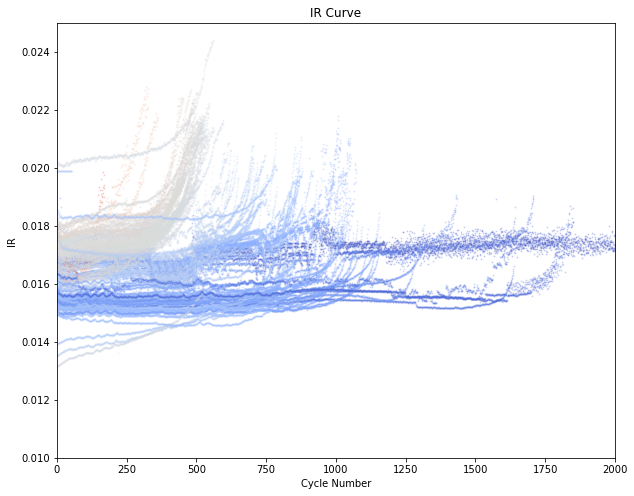

In [93]:
plt.figure(figsize=(10,8))
for i,j in enumerate(bat_dict.keys()):
    plt.scatter(bat_dict[j]['summary']['cycle'], bat_dict[j]['summary']['IR'],s=1,color=changecolor[i],alpha=0.2)
plt.xlabel('Cycle Number')
plt.xlim(0,2000)
plt.ylabel('IR')
plt.ylim(0.01,0.025)
plt.title("IR Curve")
plt.show()

# IR Curve feature
# 5.1 초기 2 Cycle 의 저항

In [130]:
# test_ind
# train_ind 
# secondary_test_ind 

# train, test, sec, 각 cycle 2 에서 IR
train_Cycle2_IR=[]
train_Cycle_life=[]

test_Cycle2_IR=[]
test_Cycle_life=[]

sec_Cycle2_IR=[]
sec_Cycle_life=[]

for i,j in enumerate(bat_dict.keys()):
    if i in train_ind :
        train_Cycle2_IR.append(bat_dict[j]['summary']['IR'][2])
        train_Cycle_life.append(bat_dict[j]['cycle_life'][0][0])
        
    if i in test_ind :
        test_Cycle2_IR.append(bat_dict[j]['summary']['IR'][2])
        test_Cycle_life.append(bat_dict[j]['cycle_life'][0][0])
            
    if i in secondary_test_ind:
        sec_Cycle2_IR.append(bat_dict[j]['summary']['IR'][2])
        sec_Cycle_life.append(bat_dict[j]['cycle_life'][0][0])

In [131]:
Train_Cycle2_IR=np.array(train_Cycle2_IR)
Train_Cycle_life=np.array(train_Cycle_life)
Test_Cycle2_IR=np.array(test_Cycle2_IR)
Test_Cycle_life=np.array(test_Cycle_life)
Sec_Cycle2_IR=np.array(sec_Cycle2_IR)
Sec_Cycle_life=np.array(sec_Cycle_life)

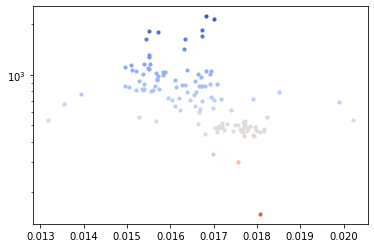

In [132]:
for i,j in enumerate(bat_dict.keys()):
    plt.scatter(bat_dict[j]['summary']['IR'][2], bat_dict[j]['cycle_life'][0][0],s=10,color=changecolor[i])
    plt.yscale('log')

In [133]:
def Z_score(Train,prim_test,secondary):
    Z1=(Train-np.mean(Train))/np.std(Train)
    Z2=(prim_test-np.mean(Train))/np.std(Train)
    Z3=(secondary-np.mean(Train))/np.std(Train)
    return Z1, Z2, Z3

In [134]:
TrainCycle2_IR=Train_Cycle2_IR.reshape(-1,1)
TestCycle2_IR=Test_Cycle2_IR.reshape(-1,1)
SecCycle2_IR=Sec_Cycle2_IR.reshape(-1,1)
Cycle_train=np.log10(Train_Cycle_life)
Cycle_test=np.log10(Test_Cycle_life)
Cycle_sec=np.log10(Sec_Cycle_life)

In [135]:
Z1_train,Z1_test,Z1_sec=Z_score(TrainCycle2_IR,TestCycle2_IR,SecCycle2_IR)

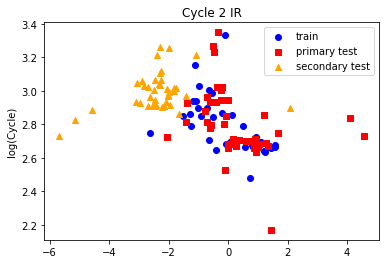

In [171]:
plt.scatter(Z1_train,Cycle_train,color='blue',marker='o',label='train')
plt.scatter(Z1_test,Cycle_test,color='red',marker='s',label='primary test')
plt.scatter(Z1_sec,Cycle_sec,color='orange',marker='^',label='secondary test')
plt.title('Cycle 2 IR')
plt.ylabel('log(Cycle)')
plt.legend()
plt.show()

# 5.2  Cycle IR slope

In [137]:
# train, test, sec, 각 2~100 cycle IR Slope
train_slope=[]

test_slope=[]

sec_slope=[]

def IRSlope(x,y):
    Train_CyclePoint=np.array(range(x,y)).reshape(-1,1)
    IR_point=[]
    for k in range(x,y):
        IR_point.append(bat_dict[j]['summary']['IR'][k])
    label_IRPoint=np.array(IR_point).ravel()
    reg=LinearRegression()
    reg.fit(Train_CyclePoint,label_IRPoint)
    
    return reg.coef_

from sklearn.linear_model import LinearRegression

for i,j in enumerate(bat_dict.keys()):
    if i in train_ind :
        slope=IRSlope(2,101)
        train_slope.append(slope)
        
    if i in test_ind :
        slope=IRSlope(2,101)
        test_slope.append(slope)        
            
    if i in secondary_test_ind:
        slope=IRSlope(2,101)
        sec_slope.append(slope)        

In [138]:
Train_slope=np.array(train_slope).reshape(-1,1)
Test_slope=np.array(test_slope).reshape(-1,1)
Sec_slope=np.array(sec_slope).reshape(-1,1)

In [139]:
Z2_train,Z2_test,Z2_sec=Z_score(Train_slope,Test_slope,Sec_slope)

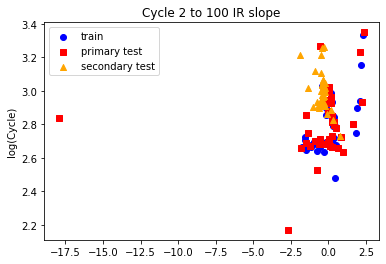

In [172]:
plt.scatter(Z2_train,Cycle_train,color='blue',marker='o',label='train')
plt.scatter(Z2_test,Cycle_test,color='red',marker='s',label='primary test')
plt.scatter(Z2_sec,Cycle_sec,color='orange',marker='^',label='secondary test')
plt.title('Cycle 2 to 100 IR slope')
plt.ylabel('log(Cycle)')
plt.legend()
plt.show()

# 5.3 IR Variance

In [142]:
# IR 값의 분산 2~100
train_var=[]

test_var=[]

sec_var=[]

def varIR(x,y):
    IR_point=[]
    for k in range(x,y):
        IR_point.append(bat_dict[j]['summary']['IR'][k])
    a=np.array(IR_point)
    var_IR=np.var(a)
    return var_IR

for i,j in enumerate(bat_dict.keys()):
    if i in train_ind :
        var=varIR(2,101)
        train_var.append(var)
        
    if i in test_ind :
        var=varIR(2,101)
        test_var.append(var)        
            
    if i in secondary_test_ind:
        var=varIR(2,101)
        sec_var.append(var)

In [143]:
Train_var=np.array(train_var).reshape(-1,1)
Test_var=np.array(test_var).reshape(-1,1)
Sec_var=np.array(sec_var).reshape(-1,1)

In [144]:
Z3_train,Z3_test,Z3_sec=Z_score(Train_var,Test_var,Sec_var)

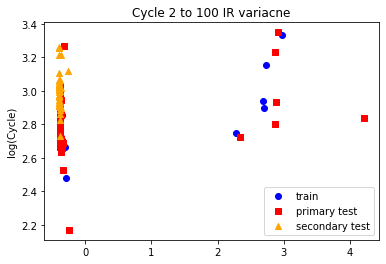

In [173]:
plt.scatter(Z3_train,Cycle_train,color='blue',marker='o',label='train')
plt.scatter(Z3_test,Cycle_test,color='red',marker='s',label='primary test')
plt.scatter(Z3_sec,Cycle_sec,color='orange',marker='^',label='secondary test')
plt.title('Cycle 2 to 100 IR variacne')
plt.ylabel('log(Cycle)')
plt.legend()
plt.show()

In [235]:
# IR 값의 분산 2~100
train_mean=[]

test_mean=[]

sec_mean=[]

def meanIR(x,y):
    IR_point=[]
    for k in range(x,y):
        IR_point.append(bat_dict[j]['summary']['IR'][k])
    a=np.array(IR_point)
    mean_IR=np.mean(a)
    return mean_IR

for i,j in enumerate(bat_dict.keys()):
    if i in train_ind :
        mean=meanIR(2,101)
        train_mean.append(mean)
        
    if i in test_ind :
        mean=meanIR(2,101)
        test_mean.append(mean)        
            
    if i in secondary_test_ind:
        mean=meanIR(2,101)
        sec_mean.append(mean)

In [236]:
Train_mean=np.array(train_mean).reshape(-1,1)
Test_mean=np.array(test_mean).reshape(-1,1)
Sec_mean=np.array(sec_mean).reshape(-1,1)

In [237]:
Z4_train,Z4_test,Z4_sec=Z_score(Train_mean,Test_mean,Sec_mean)

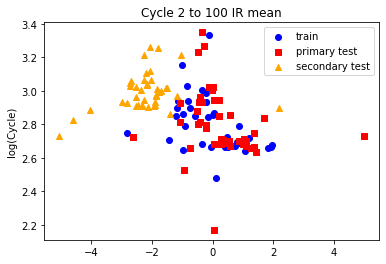

In [238]:
plt.scatter(Z4_train,Cycle_train,color='blue',marker='o',label='train')
plt.scatter(Z4_test,Cycle_test,color='red',marker='s',label='primary test')
plt.scatter(Z4_sec,Cycle_sec,color='orange',marker='^',label='secondary test')
plt.title('Cycle 2 to 100 IR mean')
plt.ylabel('log(Cycle)')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Cycle 2 to 100 IR variacne')

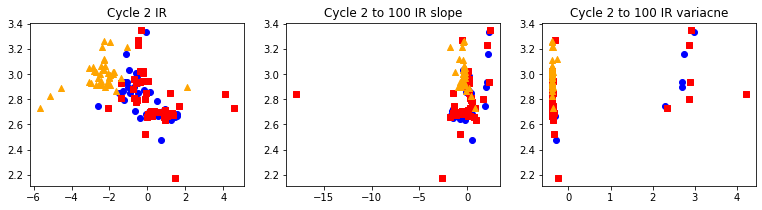

In [234]:
fig=plt.figure(figsize=(13,3))
ax1=fig.add_subplot(1,3,1)
ax1.scatter(Z1_train,Cycle_train,color='blue',marker='o',label='train')
ax1.scatter(Z1_test,Cycle_test,color='red',marker='s',label='primary test')
ax1.scatter(Z1_sec,Cycle_sec,color='orange',marker='^',label='secondary test')
ax1.set_title('Cycle 2 IR')

ax2=fig.add_subplot(1,3,2)
ax2.scatter(Z2_train,Cycle_train,color='blue',marker='o',label='train')
ax2.scatter(Z2_test,Cycle_test,color='red',marker='s',label='primary test')
ax2.scatter(Z2_sec,Cycle_sec,color='orange',marker='^',label='secondary test')
ax2.set_title('Cycle 2 to 100 IR slope')

ax3=fig.add_subplot(1,3,3)
ax3.scatter(Z3_train,Cycle_train,color='blue',marker='o',label='train')
ax3.scatter(Z3_test,Cycle_test,color='red',marker='s',label='primary test')
ax3.scatter(Z3_sec,Cycle_sec,color='orange',marker='^',label='secondary test')
ax3.set_title('Cycle 2 to 100 IR variacne')

In [149]:
#train,primary, secondary data 만들기
Train=np.hstack([Z1_train,Z2_train,Z3_train])
Test=np.hstack([Z1_test,Z2_test,Z3_test])
Sec=np.hstack([Z1_sec,Z2_sec,Z3_sec])
#train, primary, secondary 정답 데이터 만들기
label_train=Cycle_train.ravel()
label_test=Cycle_test.ravel()
label_sec=Cycle_sec.ravel()

In [151]:
Train.shape,Test.shape,Sec.shape

((41, 3), (43, 3), (40, 3))

# Lasso (LassoCV 4-fold)

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # Remove the CWD from sys.path while we load stuff.
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2872543467413846, tolerance: 0.00010703521221153374
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

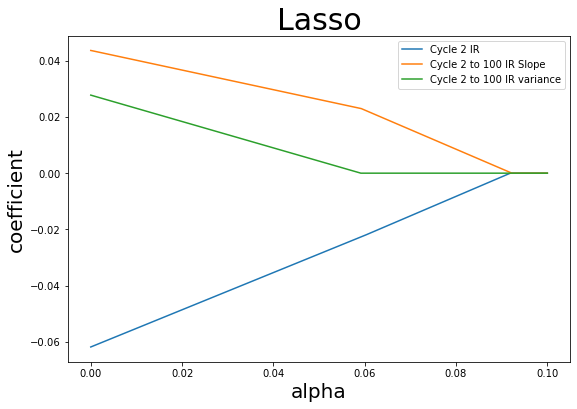

In [152]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
Y=[]
X=[]

plt.figure(figsize=(9,6))
for i in np.linspace(0,0.1,1000):
    regrplot=Lasso(alpha=i)
    regrplot.fit(Train,label_train)
    Y.append(regrplot.coef_)
    X.append(i)
Y_=np.array(Y)    
plt.plot(X,Y_[:,0],label='Cycle 2 IR')
plt.plot(X,Y_[:,1],label='Cycle 2 to 100 IR Slope')
plt.plot(X,Y_[:,2],label='Cycle 2 to 100 IR variance')
plt.title('Lasso',size=30)
plt.xlabel('alpha',size=20)
plt.ylabel('coefficient',size=20)
plt.legend()
plt.show


In [154]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
from sklearn.metrics import mean_squared_error

In [155]:
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=4).fit(Train,label_train)
print('Lasso CV alpha:',reg.alpha_)
print('Lasso CV coefficient:',reg.coef_)
print('Lasso CV intercept:',reg.intercept_)

Lassocv=reg.predict(Train)
rmseLassocv=np.sqrt(mean_squared_error(10**label_train,10**Lassocv))
print('RMSE','           ','MAPE')
print(rmseLassocv,MAPE(10**label_train,10**Lassocv))

Lasso CV alpha: 0.0006064018165032118
Lasso CV coefficient: [-0.0614086   0.04343705  0.02747111]
Lasso CV intercept: 2.793969897643637
RMSE             MAPE
262.6826557843478 19.83366688125078


In [156]:
Lassocv2=reg.predict(Test)
rmseLassocv2=np.sqrt(mean_squared_error(10**label_test,10**Lassocv2))
print('RMSE','           ','MAPE')
print(rmseLassocv2,MAPE(10**label_test,10**Lassocv2))

RMSE             MAPE
356.2312478365782 29.61760497636324


In [157]:
Lassocv3=reg.predict(Sec)
rmseLassocv3=np.sqrt(mean_squared_error(10**label_sec,10**Lassocv3))
print('RMSE','           ','MAPE')
print(rmseLassocv3,MAPE(10**label_sec,10**Lassocv3))

RMSE             MAPE
420.4507508069601 27.974867224162875


(array([ 0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  2.,  3.,
         2.,  7.,  6.,  7.,  1.,  7.,  5., 14.,  7.,  4.,  1.,  2.,  1.,
         0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-1000,  -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,
         -550,  -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,
         -100,   -50,     0,    50,   100,   150,   200,   250,   300,
          350,   400,   450,   500,   550,   600,   650,   700,   750,
          800,   850,   900,   950]),
 <BarContainer object of 39 artists>)

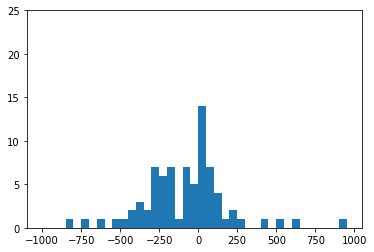

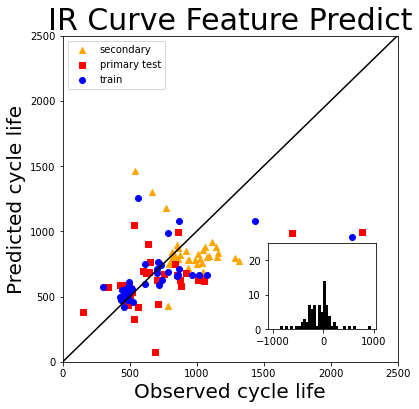

In [163]:
# Lasso 
s_res=(10**Lassocv3)-(10**label_sec)
p_res=(10**Lassocv2)-(10**label_test)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])

bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,25)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_sec,10**Lassocv3,color='orange',marker='^',label='secondary')
plt.scatter(10**label_test,10**Lassocv2,color='r',marker='s',label='primary test')
plt.scatter(10**label_train,10**Lassocv,color='b',marker='o',label='train')
plt.axis([0,2500,0,2500])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('IR Curve Feature Predict',size=30)
plt.legend()
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,25)
ax_sub.hist(his,bins,color='black')

# Ridge (RidgeCV 4-fold)

<function matplotlib.pyplot.show(close=None, block=None)>

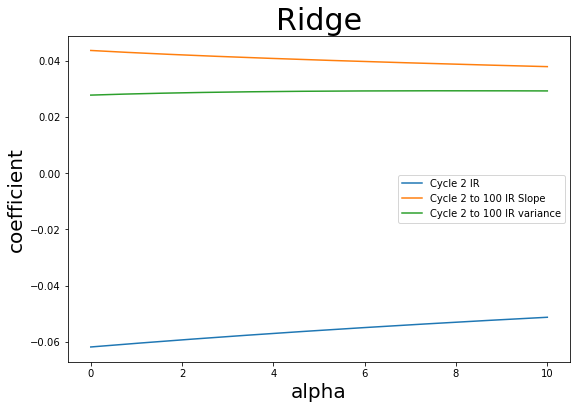

In [159]:
Y=[]
X=[]

plt.figure(figsize=(9,6))
for i in np.linspace(0,10,1000):
    regrplot=Ridge(alpha=i)
    regrplot.fit(Train,label_train)
    Y.append(regrplot.coef_)
    X.append(i)
Y_=np.array(Y)    
plt.plot(X,Y_[:,0],label='Cycle 2 IR')
plt.plot(X,Y_[:,1],label='Cycle 2 to 100 IR Slope')
plt.plot(X,Y_[:,2],label='Cycle 2 to 100 IR variance')
plt.title('Ridge',size=30)
plt.xlabel('alpha',size=20)
plt.ylabel('coefficient',size=20)
plt.legend()
plt.show

In [160]:
from sklearn.linear_model import RidgeCV
reg = RidgeCV(cv=4).fit(Train,label_train)
print('Ridge CV alpha:',reg.alpha_)
print('Ridge CV coefficient:',reg.coef_)
print('Ridge CV intercept:',reg.intercept_)

Ridgecv=reg.predict(Train)
rmseRidgecv=np.sqrt(mean_squared_error(10**label_train,10**Ridgecv))
print('RMSE','           ','MAPE')
print(rmseRidgecv,MAPE(10**label_train,10**Ridgecv))

Ridge CV alpha: 10.0
Ridge CV coefficient: [-0.05124594  0.03788929  0.02925172]
Ridge CV intercept: 2.793969897643637
RMSE             MAPE
261.9042946624726 20.073617342656437


In [161]:
Ridgecv2=reg.predict(Test)
rmseRidgecv2=np.sqrt(mean_squared_error(10**label_test,10**Ridgecv2))
print('RMSE','           ','MAPE')
print(rmseRidgecv2,MAPE(10**label_test,10**Ridgecv2))

RMSE             MAPE
357.1613072431291 29.67900169625924


In [162]:
Ridgecv3=reg.predict(Sec)
rmseRidgecv3=np.sqrt(mean_squared_error(10**label_sec,10**Ridgecv3))
print('RMSE','           ','MAPE')
print(rmseRidgecv3,MAPE(10**label_sec,10**Ridgecv3))

RMSE             MAPE
422.90137606622704 28.68411975817955


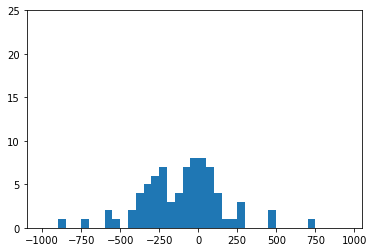

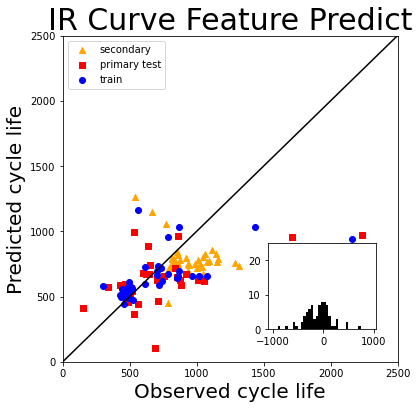

In [164]:
# Ridge
s_res=(10**Ridgecv3)-(10**label_sec)
p_res=(10**Ridgecv2)-(10**label_test)


s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])


bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,25)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_sec,10**Ridgecv3,color='orange',marker='^',label='secondary')
plt.scatter(10**label_test,10**Ridgecv2,color='red',marker='s',label='primary test')
plt.scatter(10**label_train,10**Ridgecv,color='blue',marker='o',label='train')
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.axis([0,2500,0,2500])
plt.title('IR Curve Feature Predict',size=30)
plt.legend()
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,25)
ax_sub.hist(his,bins,color='black')
plt.show()

# ElasticNet (ElasticNetCV 4-fold)

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2872543467413846, tolerance: 0.00010703521221153374
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

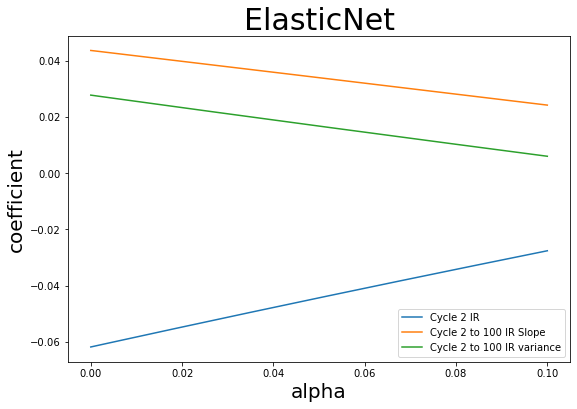

In [166]:
Y=[]
X=[]

plt.figure(figsize=(9,6))
for i in np.linspace(0,0.1,1000):
    regrplot=ElasticNet(alpha=i)
    regrplot.fit(Train,label_train)
    Y.append(regrplot.coef_)
    X.append(i)
Y_=np.array(Y)    
plt.plot(X,Y_[:,0],label='Cycle 2 IR')
plt.plot(X,Y_[:,1],label='Cycle 2 to 100 IR Slope')
plt.plot(X,Y_[:,2],label='Cycle 2 to 100 IR variance')
plt.title('ElasticNet',size=30)
plt.xlabel('alpha',size=20)
plt.ylabel('coefficient',size=20)
plt.legend()
plt.show

In [167]:
from sklearn.linear_model import ElasticNetCV
reg = ElasticNetCV(cv=4).fit(Train,label_train)
print('ElasticNet CV alpha:',reg.alpha_)
print('ElasticNet CV coefficient:',reg.coef_)
print('ElasticNet CV intercept:',reg.intercept_)

ElasticNetcv=reg.predict(Train)
rmseElasticNetcv=np.sqrt(mean_squared_error(10**label_train,10**ElasticNetcv))
print('RMSE','           ','MAPE')
print(rmseElasticNetcv,MAPE(10**label_train,10**ElasticNetcv))

ElasticNet CV alpha: 0.0012128036330064237
ElasticNet CV coefficient: [-0.06137586  0.04341447  0.02748484]
ElasticNet CV intercept: 2.793969897643637
RMSE             MAPE
262.67545445390783 19.83296442938038


In [168]:
ElasticNetcv2=reg.predict(Test)
rmseElasticNetcv2=np.sqrt(mean_squared_error(10**label_test,10**ElasticNetcv2))
print('RMSE','           ','MAPE')
print(rmseElasticNetcv2,MAPE(10**label_test,10**ElasticNetcv2))

RMSE             MAPE
356.23138310884025 29.61797425487336


In [169]:
ElasticNetcv3=reg.predict(Sec)
rmseElasticNetcv3=np.sqrt(mean_squared_error(10**label_sec,10**ElasticNetcv3))
print('RMSE','           ','MAPE')
print(rmseElasticNetcv3,MAPE(10**label_sec,10**ElasticNetcv3))

RMSE             MAPE
420.44123079450594 27.973996202174416


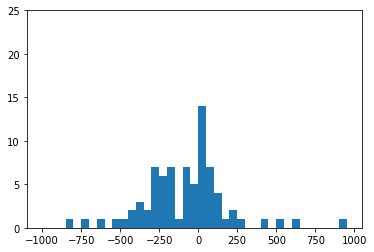

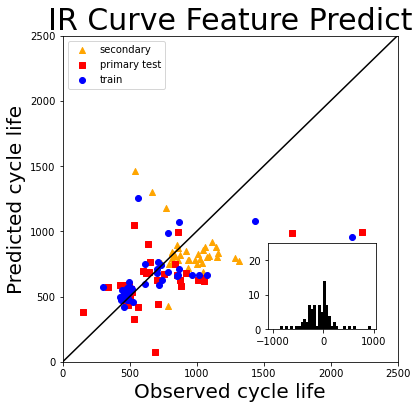

In [170]:
# ElasticNet
s_res=(10**ElasticNetcv3)-(10**label_sec)
p_res=(10**ElasticNetcv2)-(10**label_test)


s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])


bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,25)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_sec,10**ElasticNetcv3,color='orange',marker='^',label='secondary')
plt.scatter(10**label_test,10**ElasticNetcv2,color='red',marker='s',label='primary test')
plt.scatter(10**label_train,10**ElasticNetcv,color='blue',marker='o',label='train')
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.axis([0,2500,0,2500])
plt.title('IR Curve Feature Predict',size=30)
plt.legend()
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,25)
ax_sub.hist(his,bins,color='black')
plt.show()

# 1C-rate 끝나고 Q%값은?

In [174]:
bat_dict['b1c0']['summary'].keys()

dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])

In [175]:
bat_dict['b1c0']['summary']['QC']

array([0.        , 1.0710422 , 1.0716741 , ..., 0.88449496, 0.88432896,
       0.8840425 ])

In [184]:
bat_dict['b1c0']['summary']['QD']

array([0.        , 1.0706892 , 1.0719005 , ..., 0.88462406, 0.88433141,
       0.88280821])

In [182]:
Q_per=np.divide(bat_dict['b1c0']['summary']['QC'],1.1)*100

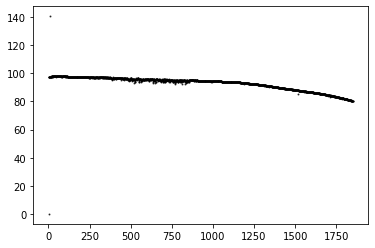

In [190]:
plt.scatter(bat_dict['b1c0']['summary']['cycle'],Q_per,c='black',s=1,alpha=0.7)

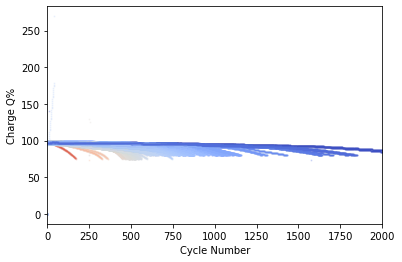

In [191]:
for i,j in enumerate(bat_dict.keys()):
    plt.scatter(bat_dict[j]['summary']['cycle'], np.divide(bat_dict[j]['summary']['QC'],1.1)*100 ,s=1,color=changecolor[i],alpha=0.2)
plt.xlabel('Cycle Number')
plt.xlim(0,2000)
plt.ylabel('Charge Q%')
# plt.ylim(0.01,0.025)
# plt.title("IR Curve")
plt.show()

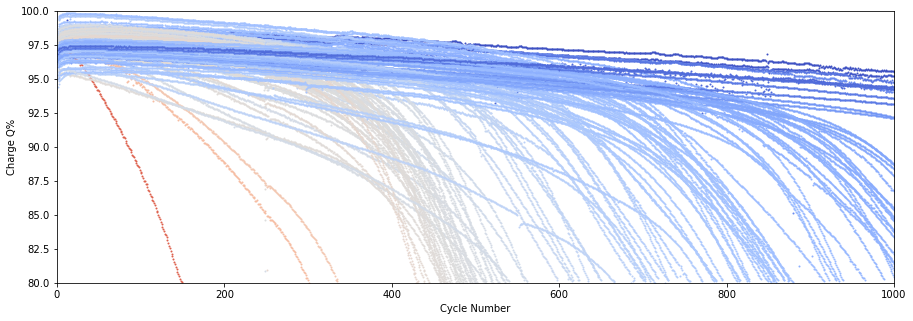

In [198]:
plt.figure(figsize=(15,5))
for i,j in enumerate(bat_dict.keys()):
    plt.scatter(bat_dict[j]['summary']['cycle'], np.divide(bat_dict[j]['summary']['QC'],1.1)*100 ,s=1,color=changecolor[i])
plt.xlabel('Cycle Number')
plt.xlim(0,1000)
plt.ylabel('Charge Q%')
plt.ylim(80,100)
# plt.title("IR Curve")
plt.show()

# 히스토그램 논문 데이터 세서 만든 것.

In [222]:
Train_hist=[400 for i in range(18)]
Test_hist=[200]
Sec_hist=[600,600]

In [223]:
for i in range(7):
    Train_hist.append(600)
for i in range(19):
    Train_hist.append(800)
for i in range(10):
    Train_hist.append(1000)
for i in range(3):
    Train_hist.append(1200)
Train_hist.append(1400)
Train_hist.append(1600)
Train_hist.append(1800)
Train_hist.append(2200)

for i in range(14):
    Test_hist.append(400)
for i in range(14):
    Test_hist.append(600)
for i in range(15):
    Test_hist.append(800)
for i in range(10):
    Test_hist.append(1000)
for i in range(3):
    Test_hist.append(1200)
Test_hist.append(1400)
for i in range(3):
    Test_hist.append(1800)
Test_hist.append(2000)
Test_hist.append(2200)

for i in range(14):
    Sec_hist.append(800)
for i in range(13):
    Sec_hist.append(1000)
for i in range(6):
    Sec_hist.append(1200)
Sec_hist.append(1400)
Sec_hist.append(1600)
for i in range(2):
    Sec_hist.append(1800)
Sec_hist.append(2000)

In [225]:
len(Train_hist),len(Test_hist),len(Sec_hist)

(61, 63, 40)

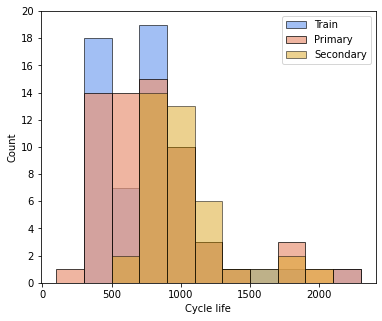

In [226]:
bins=np.arange(100,2500,200)# width 조절
plt.figure(figsize=(6,5))
plt.hist(Train_hist,bins,edgecolor='k',alpha=0.6,color='cornflowerblue',label='Train')
plt.hist(Test_hist,bins,edgecolor='k',alpha=0.7,color='darksalmon',label='Primary')
plt.hist(Sec_hist,bins,edgecolor='k',alpha=0.5,color='goldenrod',label='Secondary')
plt.yticks(np.arange(0,21,2))
plt.xlabel('Cycle life')
plt.ylabel('Count')
plt.legend()

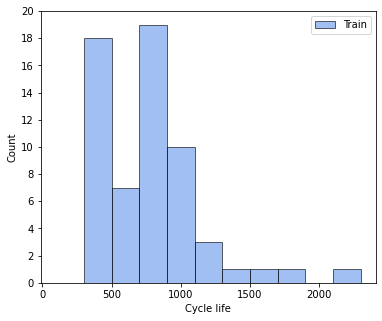

In [227]:
bins=np.arange(100,2500,200)# width 조절
plt.figure(figsize=(6,5))
plt.hist(Train_hist,bins,edgecolor='k',alpha=0.6,color='cornflowerblue',label='Train')
plt.yticks(np.arange(0,21,2))
plt.xlabel('Cycle life')
plt.ylabel('Count')
plt.legend()

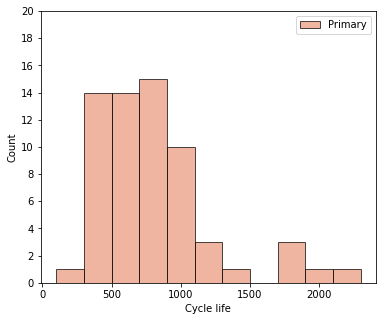

In [228]:
bins=np.arange(100,2500,200)# width 조절
plt.figure(figsize=(6,5))
plt.hist(Test_hist,bins,edgecolor='k',alpha=0.7,color='darksalmon',label='Primary')
plt.yticks(np.arange(0,21,2))
plt.xlabel('Cycle life')
plt.ylabel('Count')
plt.legend()

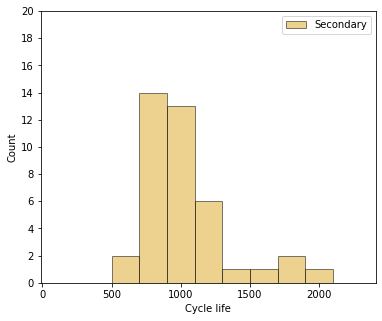

In [229]:
bins=np.arange(100,2500,200)# width 조절
plt.figure(figsize=(6,5))
plt.hist(Sec_hist,bins,edgecolor='k',alpha=0.5,color='goldenrod',label='Secondary')
plt.yticks(np.arange(0,21,2))
plt.xlabel('Cycle life')
plt.ylabel('Count')
plt.legend()

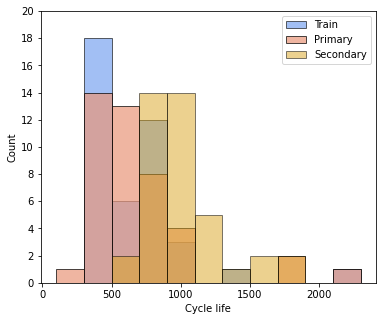

In [230]:
bins=np.arange(100,2500,200)# width 조절
plt.figure(figsize=(6,5))
plt.hist(train_label,bins,edgecolor='k',alpha=0.6,color='cornflowerblue',label='Train')
plt.hist(test_label,bins,edgecolor='k',alpha=0.7,color='darksalmon',label='Primary')
plt.hist(sec_label,bins,edgecolor='k',alpha=0.5,color='goldenrod',label='Secondary')
plt.yticks(np.arange(0,21,2))
plt.xlabel('Cycle life')
plt.ylabel('Count')
plt.legend()

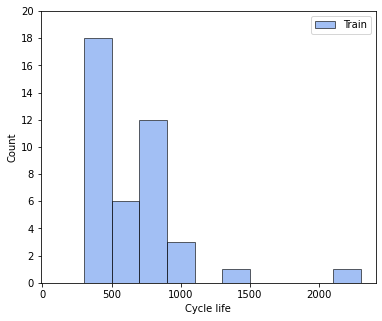

In [231]:
bins=np.arange(100,2500,200)# width 조절
plt.figure(figsize=(6,5))
plt.hist(train_label,bins,edgecolor='k',alpha=0.6,color='cornflowerblue',label='Train')
plt.yticks(np.arange(0,21,2))
plt.xlabel('Cycle life')
plt.ylabel('Count')
plt.legend()

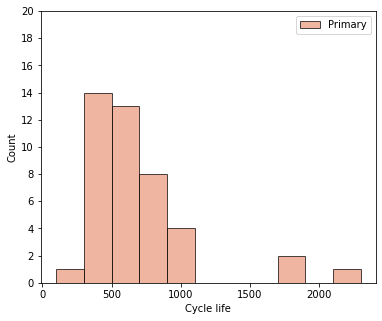

In [232]:
bins=np.arange(100,2500,200)# width 조절
plt.figure(figsize=(6,5))
plt.hist(test_label,bins,edgecolor='k',alpha=0.7,color='darksalmon',label='Primary')
plt.yticks(np.arange(0,21,2))
plt.xlabel('Cycle life')
plt.ylabel('Count')
plt.legend()

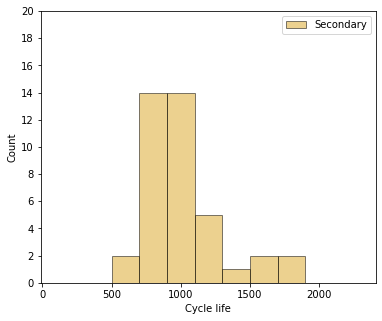

In [233]:
bins=np.arange(100,2500,200)# width 조절
plt.figure(figsize=(6,5))
plt.hist(sec_label,bins,edgecolor='k',alpha=0.5,color='goldenrod',label='Secondary')
plt.yticks(np.arange(0,21,2))
plt.xlabel('Cycle life')
plt.ylabel('Count')
plt.legend()

# Batch 정보 갖는 데이터 얻어보기 (ex. datatime or batch class )